#Setup

In [ ]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import torch.optim as optim
import torch.nn.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
from torch.utils import data
from psutil import virtual_memory
from google.colab import drive
from psutil import virtual_memory
import json
from typing import List, Tuple
import pdb
from tqdm import tqdm

#!pip install wandb --upgrade
#import wandb

In [ ]:
class SetUpColab():

  def __init__(self):
    pass
  
  #Determines how much ram the runtime has
  @staticmethod
  def runtime_info():
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
    if ram_gb < 20:
      print('Not using a high-RAM runtime')
    else:
      print('You are using a high-RAM runtime!')
    !nvidia-smi
    
  @staticmethod
  def mount_google_drive():
    drive.mount('/content/gdrive')
  
  #Sets up environement for use with kaggle api
  @staticmethod
  def set_up_kaggle():
    !pip uninstall -y kaggle
    !pip install --upgrade pip
    #!pip install kaggle==1.5.6
    !pip install kaggle
    !mkdir .kaggle

    token = {"username":"nicholasmagal","key":"9bf671834d75b58fac2b037da15f4cf0"}
    with open('/content/.kaggle/kaggle.json', 'w') as file:
      json.dump(token, file)
    
    for i in range(2):
      !chmod 600 /content/.kaggle/kaggle.json
      !cp /content/.kaggle/kaggle.json /root/.kaggle/
      !kaggle config set -n path -v /content

  @staticmethod
  def setup_wandb():
    wandb.login()

  
  #Calls above methods to do a complete Collab setup, ready to run ml models :D Note may want to change this per competition
  @staticmethod
  def complete_set_up():
    SetUpColab.runtime_info()
    SetUpColab.mount_google_drive()
    SetUpColab.set_up_kaggle()
    #SetUpColab.setup_wandb()

In [ ]:
SetUpColab.complete_set_up()
!kaggle competitions download -c 11785-fall2021-hw4p2
!unzip /content/competitions/11785-fall2021-hw4p2/11785-fall2021-hw4p2.zip

#Helper Functions

These are used to map from char -> index and vice versa

In [ ]:
def create_dictionaries(letter_list: List[str]):
    '''
    Create dictionaries for letter2index and index2letter transformations
    '''
    int_index = np.arange(len(letter_list))
    letter2index = dict(zip(letter_list, int_index))
    index2letter = dict(zip(int_index, letter_list))
    return(letter2index, index2letter)

def transform_letter_to_index(raw_transcripts: List[str]) -> List[int]:
    '''
    Transforms text input to numerical input by converting each letter 
    to its corresponding index from letter_list

    Args:
        raw_transcripts: Raw text transcripts with the shape of (N, )
    
    Return:
        transcripts: Converted index-format transcripts. This would be a list with a length of N
    '''  
    letter_to_index_translation = [letter2index[char] for char in raw_transcripts]
    return(letter_to_index_translation)
    

In [ ]:
LETTER_LIST = ['<sos>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 
               'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '-', "'", '.', '_', '+', ' ', '<eos>']
letter_list_size = len(LETTER_LIST)

Custom Dataset and Dataloader code

In [ ]:
def create_data_loader(dataset, shuffle, batch_size = 128, num_workers = 1, pin_memory = True, collate_fn = None):
  data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                                  batch_size = batch_size,
                                                  shuffle = shuffle,
                                                  num_workers = num_workers,
                                                  pin_memory = pin_memory,
                                                  collate_fn = collate_fn)
  return data_loader

In [ ]:
class UtteranceDataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X['data']
        #Converting our transcripts into numeraic form
        self.Y = np.array([np.array(transform_letter_to_index(transcript_string)) for transcript_string in Y['data']])

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):

      return torch.FloatTensor(self.X[index]), torch.LongTensor(self.Y[index])

    def collate_train_val(batch):
      """
      Return:
      pad_x: the padded x (training/validation speech data) 
      pad_y: the padded y (text labels - transcripts)
      x_len: the length of x
      y_len: the length of y
      """
      features, labels = zip(*batch)

      features_length = [len(x) for x in features]
      labels_length =[len(y) for y in labels]

      features = torch.nn.utils.rnn.pad_sequence(features, batch_first = True)
      labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first = True)

      #Features returned as B X L X Frequency Bins. There is a one to one correspondance between labels L and features L 
      #Labels returned as B X L
      return(features, features_length, labels, labels_length)

Model Sections: Starting with the Encoder

In [ ]:
class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key, value and unpacked_x_len.

    '''
    def __init__(self, input_dim, encoder_hidden_dim):
        super(Encoder, self).__init__()
        # The first LSTM layer at the bottom
        self.lstm = nn.LSTM(input_size = input_dim, hidden_size = encoder_hidden_dim, batch_first = True)


    def forward(self, x, x_len):
        """
        1. Pack your input and pass it through the first LSTM layer (no truncation)
        2. Pass it through the pyramidal LSTM layer
        3. Pad your input back to (B, T, *) or (T, B, *) shape
        4. Output Key, Value, and truncated input lens

        Key and value could be
            (i) Concatenated hidden vectors from all time steps (key == value).
            (ii) Linear projections of the output from the last pBLSTM network.
                If you choose this way, you can use the final output of
                your pBLSTM network.
        """
        #x is B X L X H_in
        x = torch.nn.utils.rnn.pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted = False)
        x, state = self.lstm(x)
        x, seq_lens = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)

        return(x, seq_lens)

Attention plot and forward function

In [ ]:
def plot_attention(attention):
    # utility function for debugging
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

class Attention(nn.Module):
    '''
    Attention is calculated using key and value from encoder and query from decoder.
    Here are different ways to compute attention and context:
    1. Dot-product attention
        energy = bmm(key, query)  (B, T, d_k)
        # Optional: Scaled dot-product by normalizing with sqrt key dimension
        # Check "attention is all you need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore...
    2. Cosine attention
        energy = cosine(query, key) # almost the same as dot-product xD 
    3. Bi-linear attention
        W = Linear transformation (learnable parameter): d_k -> d_q
        energy = bmm(key @ W, query)
    4. Multi-layer perceptron
        # Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4
    
    After obtaining unnormalized attention weights (energy), compute and return attention and context, i.e.,
    energy = mask(energy) # mask out padded elements with big negative number (e.g. -1e9)
    attention = softmax(energy)
    context = bmm(attention, value)

    5. Multi-Head Attention
        # Check "attention is all you need" Section 3.2.2
        h = Number of heads
        W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
        W_O: d_v -> d_v

        Reshape K: (B, T, d_k)
        to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
        Reshape V: (B, T, d_v)
        to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
        Reshape Q: (B, d_q)
        to (B, h, d_q // h)

        energy = Q @ K^T
        energy = mask(energy)
        attention = softmax(energy)
        multi_head = attention @ V
        multi_head = multi_head reshaped to (B, d_v)
        context = multi_head @ W_O
    '''
    def __init__(self):
        super(Attention, self).__init__()
        # Optional: dropout

    def forward(self, query, key, value, mask):
        """
        input:
            key: (batch_size, seq_len, d_k)
            value: (batch_size, seq_len, d_v)
            query: (batch_size, d_q)
        * Hint: d_k == d_v == d_q is often true if you use linear projections
        return:
            context: (batch_size, key_val_dim)
        
        """
        batch_size, len_of_sequence, hidden_dim = value.shape
        query = torch.unsqueeze(query, dim =2)
        energy = torch.squeeze(torch.bmm(value, query))
        energy_masked = energy * mask.to(device)
        m = nn.Softmax(dim =1)
        attention = m(energy_masked)


        value = torch.permute(value, (0,2,1))
        attention_permuted = torch.unsqueeze(attention, dim=2)
        context = torch.bmm(value.float(),attention_permuted.float())

        context = context
        

        return torch.squeeze(context), attention
        # we return attention weights for plotting (for debugging)

Decoder

In [ ]:
class Decoder(nn.Module):
  '''
  As mentioned in a previous recitation, each forward call of decoder deals with just one time step.
  Thus we use LSTMCell instead of LSTM here.
  The output from the last LSTMCell can be used as a query for calculating attention.
  Methods like Gumble noise and teacher forcing can also be incorporated for improving the performance.
  '''
  def __init__(self, vocab_size, context_size, decoder_hidden_dim, embed_dim):
      super(Decoder, self).__init__()
      # Hint: Be careful with the padding_idx
      self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embed_dim )
      # The number of cells is defined based on the paper
      self.lstm1 = nn.LSTMCell(input_size = embed_dim + context_size, hidden_size = decoder_hidden_dim)

      self.attention = Attention()     
      self.vocab_size = vocab_size
      # Optional: Weight-tying
      self.character_prob = nn.Linear(decoder_hidden_dim + context_size, vocab_size) #: d_v -> vocab_size
      self.context_size = context_size
        
        # Weight tying
        #self.character_prob.weight = self.embedding.weight

  def forward(self, value, encoder_len, y=None, key=None, mode='train'):

    B, key_seq_max_len, key_value_size = value.shape

    if mode == 'train':
      max_len =  y.shape[1]
      # B X max_length --> B X max_length X embedding dim
      label_char_embeddings = self.embedding(y)
    else:
      max_len = 600

    #Since we have variable length in our encoder, must mask attention weights
    mask = np.ones((B, key_seq_max_len))

    for batch_index in range(B):
      mask[batch_index, encoder_len[batch_index].item():] = -1e9
    mask = torch.from_numpy(mask)
    mask.requires_grad = False 

    predictions = []
    attention_plot = []

    #Init vars. Prediction will be 0 since <sos> corresponds to 0
    prediction =  torch.full((B,), fill_value = 0).to(device)
    hidden_state = None
    context = torch.zeros(B,self.context_size).to(device)

    #We must loop through time
    for time_step in range(max_len):

      #Train mode gives us the possiblity of teacher forcing
      if mode == 'train':
        teacher_forcing_draw = np.random.binomial(1,.95, 1)

        #if teacher_forcing is activated
        #if True:
        if teacher_forcing_draw == 1:

          #special case for first timestep, must input <sos>
          if time_step == 0:
            char_embeded = self.embedding(prediction)

          #Otherwise do generic teacher forcing
          else:
            #label_char_embedding B x S X Hidden dim
            char_embeded = label_char_embeddings[:, time_step - 1, :]
        #if we are not using teacher forcing
        else:
          if time_step == 0:
            char_embeded = self.embedding(prediction)
          else:
            char_embeded = self.embedding(torch.argmax(prediction, dim = 1).long())

      else: 
        char_embeded = self.embedding(torch.argmax(prediction, dim = 1).long())

      #Input into lstm is both context(from attention) and also embedding
      context_and_embedding = torch.cat((char_embeded, context), dim = 1)
      hidden_states = self.lstm1(context_and_embedding.float())
      query = hidden_states[0]
      context, attention = self.attention(query, value, value, mask)

      #pdb.set_trace()
      # We store the first attention of this batch for debugging we cut off the
      attention_plot.append(attention[0][:encoder_len[0]].detach().cpu())

      if len(context.shape)==1:
        context = torch.unsqueeze(context, 0)

      output_context = torch.cat((query, context), dim= 1)

      prediction = self.character_prob(output_context.float())
      predictions.append(prediction)

    attentions = torch.stack(attention_plot, dim=0)
    attentions = attentions[:encoder_len[0], :]
    predictions = torch.stack(predictions, dim=1)
    return predictions, attentions

In [ ]:
class Seq2Seq(nn.Module):
    '''
    We train an end-to-end sequence to sequence model comprising of Encoder and Decoder.
    This is simply a wrapper "model" for your encoder and decoder.
    '''
    def __init__(self,input_dim, encoder_hidden_dim, vocab_size, context_size, decoder_hidden_dim, embed_dim):
        super(Seq2Seq,self).__init__()
        self.encoder = Encoder(input_dim = input_dim, encoder_hidden_dim = encoder_hidden_dim)
        self.decoder = Decoder(vocab_size = letter_list_size, context_size = encoder_hidden_dim, decoder_hidden_dim = encoder_hidden_dim, embed_dim =embed_dim)

    def forward(self, x, x_len, y=None, mode='train'):
        value, encoder_len = self.encoder(x, x_len)
        predictions, attentions = self.decoder(value, encoder_len, y=y, mode=mode)
        return predictions, attentions

In [ ]:
def train(model, train_loader, criterion, optimizer):
  model.train()
  running_loss = 0

  for features, features_length, labels, labels_length in tqdm(train_dataloader):
    optimizer.zero_grad()
    features, labels = features.to(device), labels.to(device)

    #Output is shape B X S X C
    output, attentions = seq_to_seq_model(features, features_length, labels)

    output = torch.permute(output,(0,2,1))
    loss = criterion(output, labels)

    mask = np.ones((len(labels_length), max(labels_length)))
    for batch_index in range(len(labels_length)):
      mask[batch_index, labels_length[batch_index]:] = 0
    mask = torch.from_numpy(mask).to(device)
    mask.requires_grad = False

    loss = loss * mask
    loss = torch.sum(loss)
    loss = loss/np.sum(labels_length) 

    loss.backward()

    optimizer.step()
    running_loss += loss.item()

  plot_attention(attentions)

  average_loss = running_loss/len(train_loader.dataset)
  print(f"Epoch:{epoch}, Training Loss:{average_loss}")

In [ ]:
def validate(model, validate_loader,criterion):
  model.eval()
  running_loss = 0
  attention_list = []
  i = 0
  for features, features_length, labels, labels_length in (tqdm(validate_loader)):
    features, labels = features.to(device), labels.to(device)
      
    if i ==10:
      break
    i+=1
    #Output is shape B X S X C
    output, attentions = seq_to_seq_model(features, features_length, labels)

    output = torch.permute(output,(0,2,1))
    loss = criterion(output, labels)

    mask = np.ones((len(labels_length), max(labels_length)))
    for batch_index in range(len(labels_length)):
      mask[batch_index, labels_length[batch_index]:] = 0
    mask = torch.from_numpy(mask).to(device)
    mask.requires_grad = False

    loss = loss * mask
    loss = torch.sum(loss)
    loss = loss/np.sum(labels_length) 
    running_loss += loss.item()

    attention_list.append(attentions.detach().cpu().numpy().T) 
    plot_attention(attentions)
    #pdb.set_trace()

  average_loss = running_loss/len(validate_loader.dataset)
  print(f"Epoch:{epoch}, Validation Loss:{average_loss}")
  return(attention_list)


#Demo

In [ ]:
config = {'input_dim' : 40,
          'encoder_hidden_dim/context_size': 516,
          'vocab_size' : letter_list_size,
          'decoder_hidden_dim' : 516,
          'embed_dim'  : 400,
          'epochs' : 50,
          'lr' : 2e-3,
          'weight_decay' : 5e-6,
          'batch_size' : 256
          }
          
seq_to_seq_model = Seq2Seq(input_dim = config['input_dim'], 
                  encoder_hidden_dim = config['encoder_hidden_dim/context_size'],
                  vocab_size = config['vocab_size'],
                  context_size = config['encoder_hidden_dim/context_size'],
                  decoder_hidden_dim =config['decoder_hidden_dim'],
                  embed_dim = config['embed_dim']
                  )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seq_to_seq_model.to(device)
optimizer = torch.optim.Adam(seq_to_seq_model.parameters(),lr =config['lr'] , weight_decay=config['weight_decay'])
criterion = nn.CrossEntropyLoss(reduction='none')
letter2index, index2letter = create_dictionaries(LETTER_LIST)

train_features = np.load('/content/hw4p2_toy_dataset/hw4p2_toy_dataset/train.npz', allow_pickle=True, encoding = 'bytes')
train_transcripts = np.load('/content/hw4p2_toy_dataset/hw4p2_toy_dataset/train_transcripts.npz', allow_pickle=True, encoding = 'bytes')

val_features = np.load('/content/hw4p2_toy_dataset/hw4p2_toy_dataset/dev.npz', allow_pickle=True, encoding = 'bytes')
val_transcripts = np.load('/content/hw4p2_toy_dataset/hw4p2_toy_dataset/dev_transcripts.npz', allow_pickle=True, encoding = 'bytes')

dataset = UtteranceDataset(train_features,train_transcripts)
val_dataset = UtteranceDataset(val_features, val_transcripts)

train_dataloader = create_data_loader(dataset, collate_fn=UtteranceDataset.collate_train_val, shuffle = True, batch_size = config['batch_size']
                                      , num_workers=1, pin_memory=True)
validate_dataloader = create_data_loader(val_dataset, collate_fn=UtteranceDataset.collate_train_val, shuffle = False, batch_size = 1
                                      , num_workers=1, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


In [ ]:
for epoch in range(config['epochs']):
  train(seq_to_seq_model, train_dataloader, criterion, optimizer)

#Grabbing attentions

  0%|          | 0/100 [00:00<?, ?it/s]

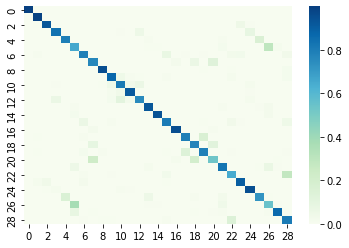

  1%|          | 1/100 [00:00<00:37,  2.61it/s]

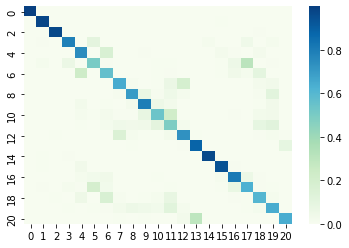

  2%|▏         | 2/100 [00:00<00:31,  3.10it/s]

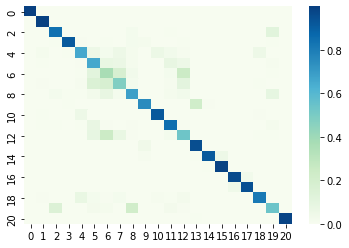

  3%|▎         | 3/100 [00:01<00:34,  2.80it/s]

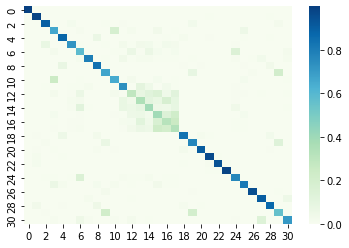

  4%|▍         | 4/100 [00:01<00:31,  3.09it/s]

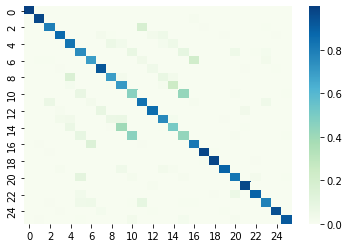

  5%|▌         | 5/100 [00:01<00:28,  3.31it/s]

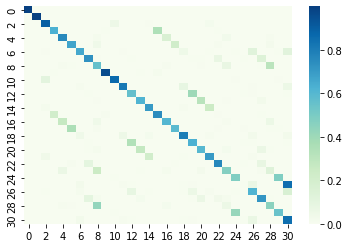

  6%|▌         | 6/100 [00:01<00:27,  3.45it/s]

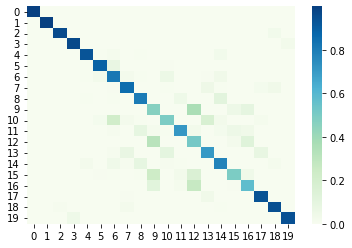

  7%|▋         | 7/100 [00:02<00:27,  3.40it/s]

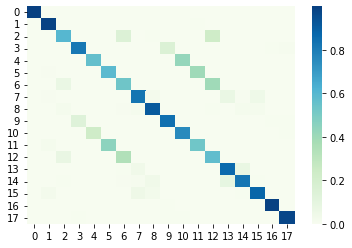

  8%|▊         | 8/100 [00:02<00:26,  3.42it/s]

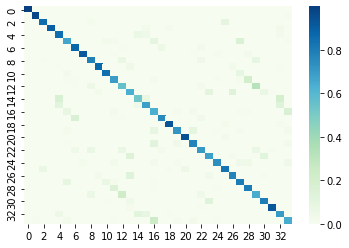

  9%|▉         | 9/100 [00:02<00:26,  3.45it/s]

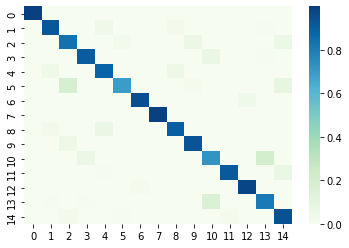

 10%|█         | 10/100 [00:03<00:27,  3.29it/s]

Epoch:49, Validation Loss:0.045435716137694794


In [ ]:
validation_attentions = validate(seq_to_seq_model,validate_dataloader,criterion )
validation_attentions = np.asarray(validation_attentions, dtype=object)

#Saving Results

In [ ]:
np.save('/content/gdrive/MyDrive/IDL/HW/HW4/P2/handin/attention', validation_attentions)

In [ ]:
for attention in (validation_attentions):
  for index, col in enumerate(range(attention.shape[1])):
    print('Row sum at',index)
    at = attention[index,: ]
    sum = (np.sum(at))
    print('torch sum',sum.item())

In [ ]:
attention[:, index]

29